In [1]:
from __future__ import division

from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

import sphereml
from scipy.optimize import differential_evolution
from pyfde import JADE
%run algorithms/genetic.py
import time
import functions

from joblib import Parallel, delayed
import pyformulas as pf

factor = 1.3

In [2]:
def run_evaluation(func_n, dims, algo, n_it, popsize=None, sbbx_eta=1.0, log=False, seed=283636):
    func = getattr(functions, f"f{func_n}")
    lb = functions.lbound[func_n - 1]
    rb = functions.rbound[func_n - 1]
    
    def helper(ind):
        helper.calls += 1
        return -func(np.array(ind))
    helper.calls = 0
    
    hist = []
    limits = [(lb, rb)]*dims
    
    if popsize is None: popsize = 5*len(limits)
    if popsize > n_it: raise AssertionError(f"popsize({popsize}) should be < n_it({n_it})")
    
    def gen_callback(fitness):
        hist.append((helper.calls, fitness))
        #print("hist: {} {}".format(len(hist), hist[-1]))
        if helper.calls > n_it:
            return True
    
    if algo == 'JADE':
        solver = JADE(helper, n_dim=len(limits), n_pop=popsize, limits=limits)
        for _ in range(int(n_it/popsize)):
            best, fit = solver.run(n_it=1)
            hist.append((helper.calls, fit))
            
    elif algo == 'DE':
        def de_callback(xk, convergence):
            hist.append((helper.calls, -func(np.array(xk))))
            if helper.calls > n_it:
                return True
        
        result = differential_evolution(lambda t: -helper(t), limits,
                               callback=de_callback, popsize=popsize, maxiter=n_it)
        best, fit = result.x, -result.fun
    
    elif algo == 'genetic':
        best, fit = genetic(helper,
                            limits=limits, popsize=popsize, generations=n_it, sbbx_eta=sbbx_eta, log=False,
                            callback=gen_callback)
    elif algo == '1+1':
        best, fit = one_plus_one(helper, limits=limits, log=False, callback=gen_callback)
    elif algo == 'CMA':
        print("TODO")
    else:
        raise AssertionError("Unknown algo")
    
    if log:
        print("{}: best {} for ind {}".format(algo, fit, best))
    return best, fit, hist

In [3]:
def run_evaluations(runs=50, *args, **kwargs):
    res = []
    for run in range(runs):
        _, _, hist = run_evaluation(*args, **kwargs)
        res.append(hist)
    return np.array(res)

In [5]:
r = run_evaluations(runs=10, func_n=1, dims=30, algo='1+1', n_it=30000)

In [11]:
res = json.load(open("results/f/results.json"))
for dims in [30, 100]:
    res[dims] = res[f"{dims}"]
    del res[f"{dims}"]

    for func_n in range(1, 14):
        res[dims][func_n] = res[dims][f"{func_n}"]
        del res[dims][f"{func_n}"]
        
        for algo in res[dims][func_n].keys():
            mean = np.array(list(map(np.array, res[dims][func_n][algo][0])))
            error = res[dims][func_n][algo][1]
            res[dims][func_n][algo] = (mean, error)

In [ ]:
json.dump(res, open("results/f/results.json", 'w'), cls=NumpyEncoder)

In [14]:
%%time

res = {}

for (n_it, dims) in [(100000, 30), (300000, 100)]: # [(30000, 30)]:
    res[dims] = {}
    for func_n in range(1, 14):
        res[dims][func_n] = {}
        print(f"{dims} f{func_n}")
        for algo in ['1+1']:#['JADE', 'DE', 'genetic', '1+1']:
            print(f"{algo}")
            r = run_evaluations(runs=5, func_n=func_n, dims=30, algo=algo, n_it=n_it)
            
            if algo == '1+1':
                length = min(map(len, r))
                r = np.array([np.array(xi)[:length] for xi in r])
            else:
                r = np.array(r)
            ggr=r
            
            mean = r.mean(axis=0)
            error = r.max(axis=0) - r.mean(axis=0)

            res[dims][func_n][algo] = (mean, error[:,1])
            
json.dump(res, open("results/f/temp_res.json", 'w'), cls=NumpyEncoder)

30 f1
1+1
30 f2
1+1
30 f3
1+1
30 f4
1+1
30 f5
1+1
30 f6
1+1
30 f7
1+1
30 f8
1+1
30 f9
1+1
30 f10
1+1
30 f11
1+1
30 f12
1+1
30 f13
1+1
100 f1
1+1
100 f2
1+1
100 f3
1+1
100 f4
1+1
100 f5
1+1
100 f6
1+1
100 f7
1+1
100 f8
1+1
100 f9
1+1
100 f10
1+1
100 f11
1+1
100 f12
1+1
100 f13
1+1
CPU times: user 1h 37min 23s, sys: 15.1 s, total: 1h 37min 38s
Wall time: 1h 38min 52s


In [16]:
for dims in [30, 100]:
    for func_n in range(1, 14):
        all_res[dims][func_n]["1+1"]=res[dims][func_n]["1+1"]

In [17]:
res = all_res

In [58]:
min(map(len, res[30][1]["JADE"][0]))

2

100 0 JADE
100 0 genetic
100 0 1+1
100 1 JADE
100 1 genetic
100 1 1+1
100 2 JADE
100 2 genetic
100 2 1+1
100 3 JADE
100 3 genetic
100 3 1+1
100 4 JADE
100 4 genetic
100 4 1+1
100 5 JADE
100 5 genetic
100 5 1+1
100 6 JADE
100 6 genetic
100 6 1+1
100 7 JADE
100 7 genetic
100 7 1+1
100 8 JADE
100 8 genetic
100 8 1+1
100 9 JADE
100 9 genetic
100 9 1+1
100 10 JADE
100 10 genetic
100 10 1+1
100 11 JADE
100 11 genetic
100 11 1+1
100 12 JADE
100 12 genetic
100 12 1+1


/home/jackson/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/jackson/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


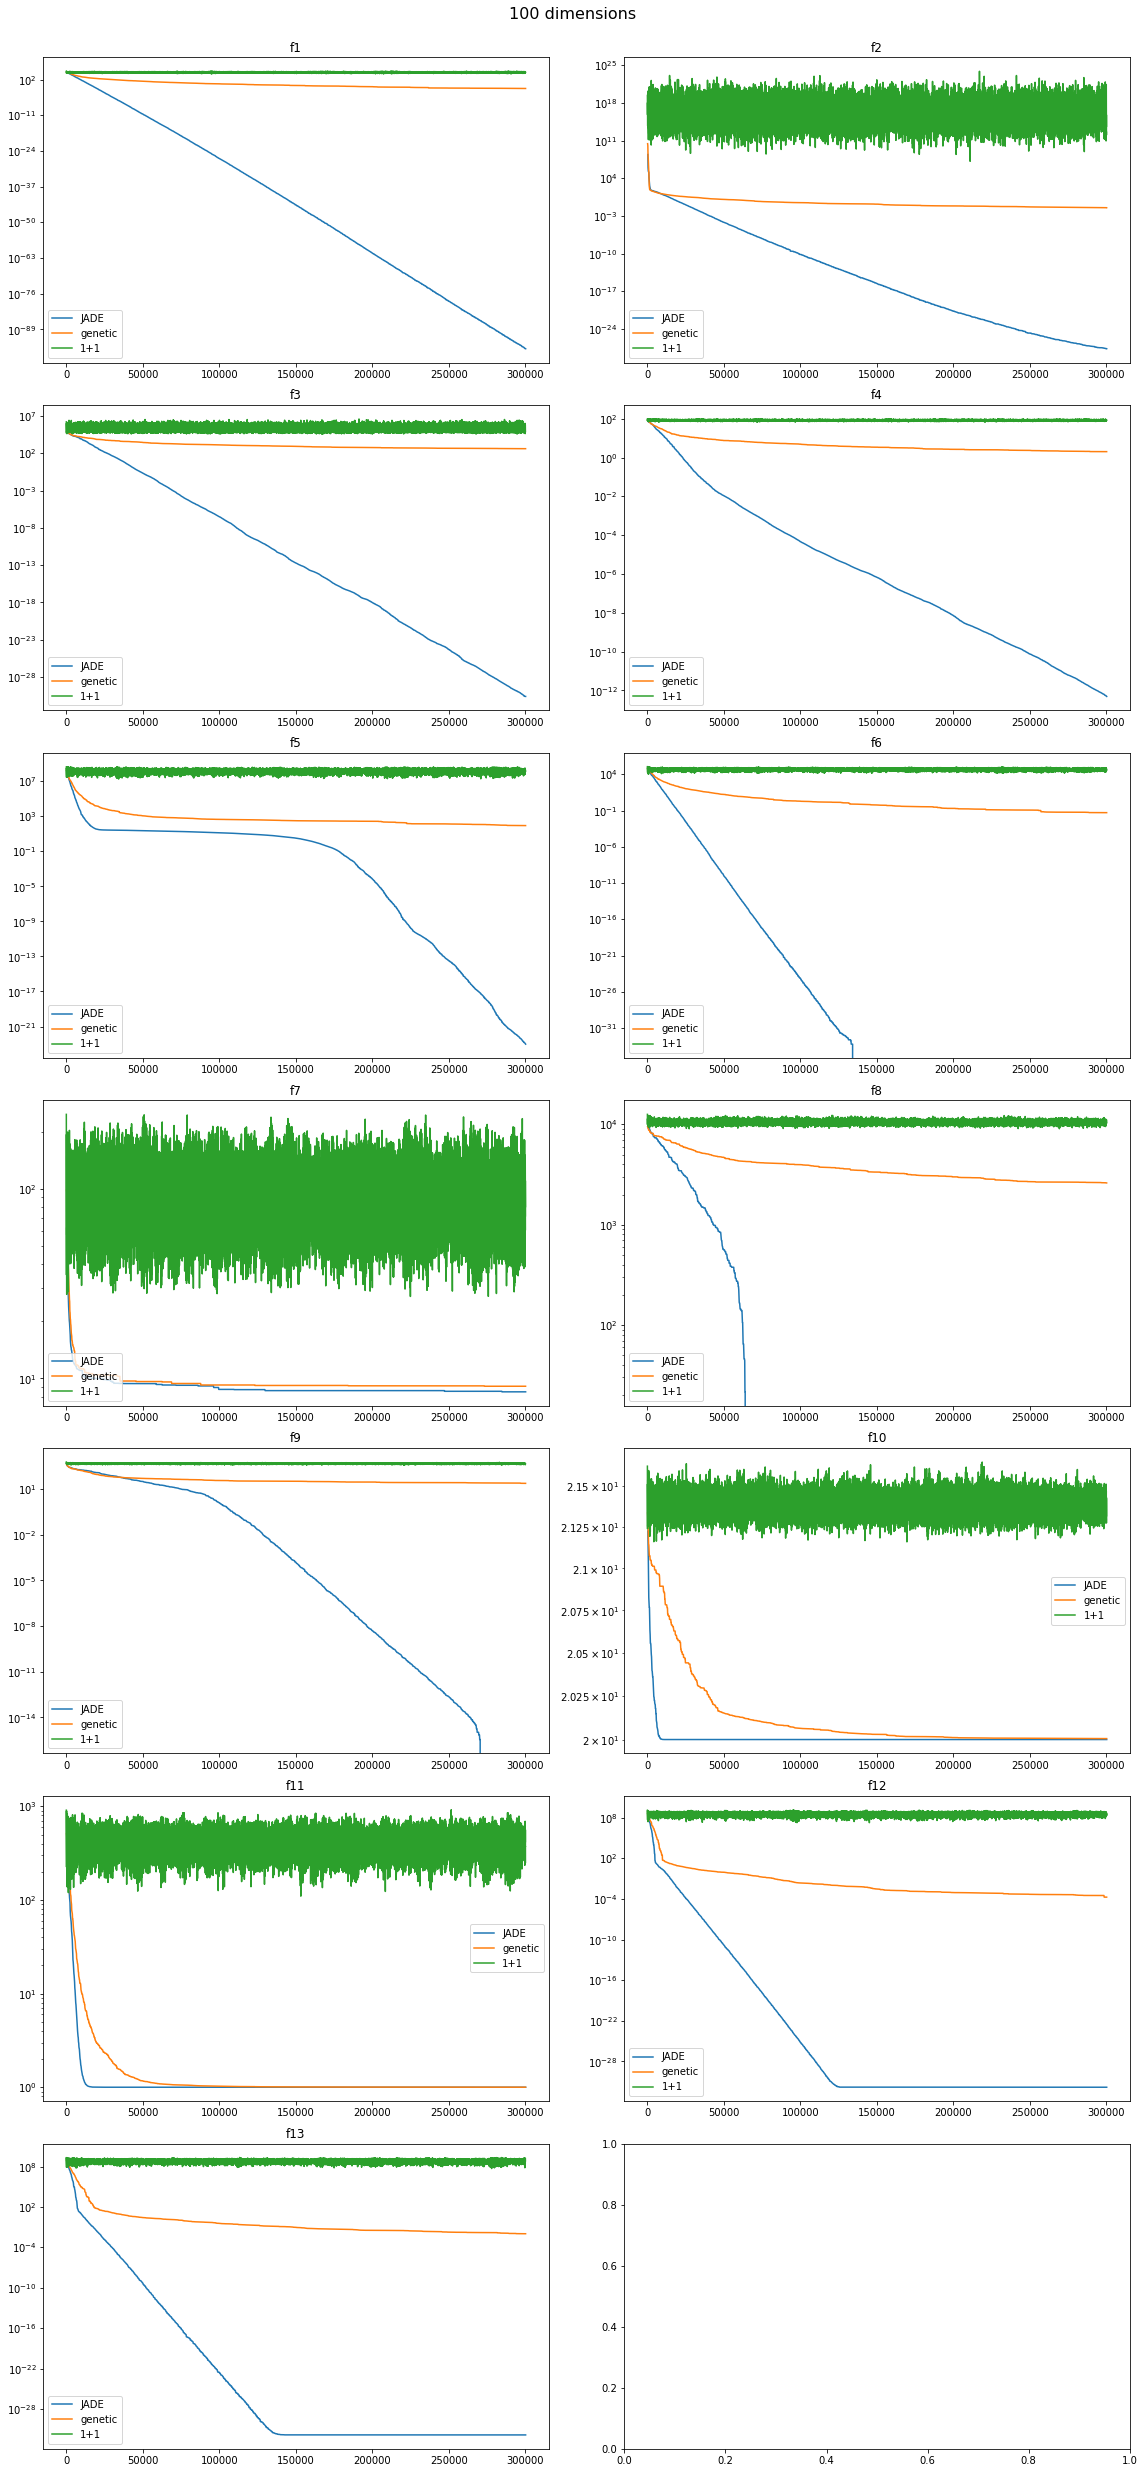

In [65]:
fig, axes = plt.subplots(7, 2, figsize=(16,5*7))

dims = 100
fig.suptitle(f'{dims} dimensions', fontsize=16)
for func_n in range(0, 13):
    ax = axes[func_n // 2, func_n % 2]
    ax.set_title(f"f{func_n + 1}")
    
    for algo in ['JADE', 'genetic', '1+1']:
        r = res[dims][func_n + 1][algo]
        
        xs = r[0][:,0]
        ys = -r[0][:,1]
        error = r[1]
        if True or algo == '1+1':
            ax.plot(xs, ys, label=algo)
        else:
            ax.errorbar(xs, ys, yerr=error, fmt='-o', label=algo)
        ax.set_yscale('log')
        ax.legend();
        
fig.tight_layout()
fig.subplots_adjust(top=0.96)

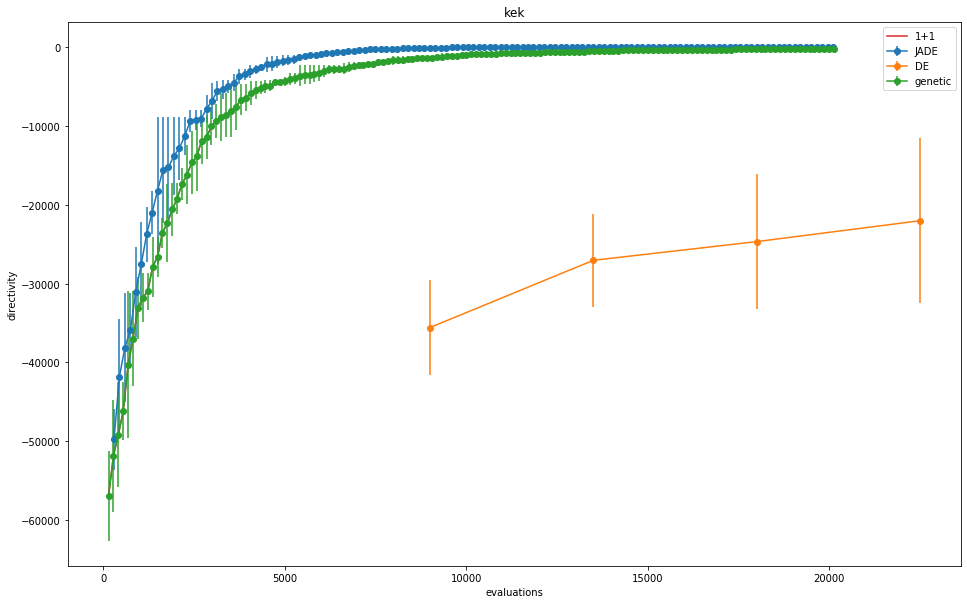

In [279]:
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("kek")
for algo in ['JADE', 'DE', 'genetic', '1+1']:
    xs = res[30][1][algo][0][:,0]
    ys = res[30][1][algo][0][:,1]
    error = res[30][1][algo][1]
    if algo == '1+1':
        plt.plot(xs, ys, label=algo)
    else:
        plt.errorbar(xs, ys, yerr=error, fmt='-o', label=algo)
plt.legend();

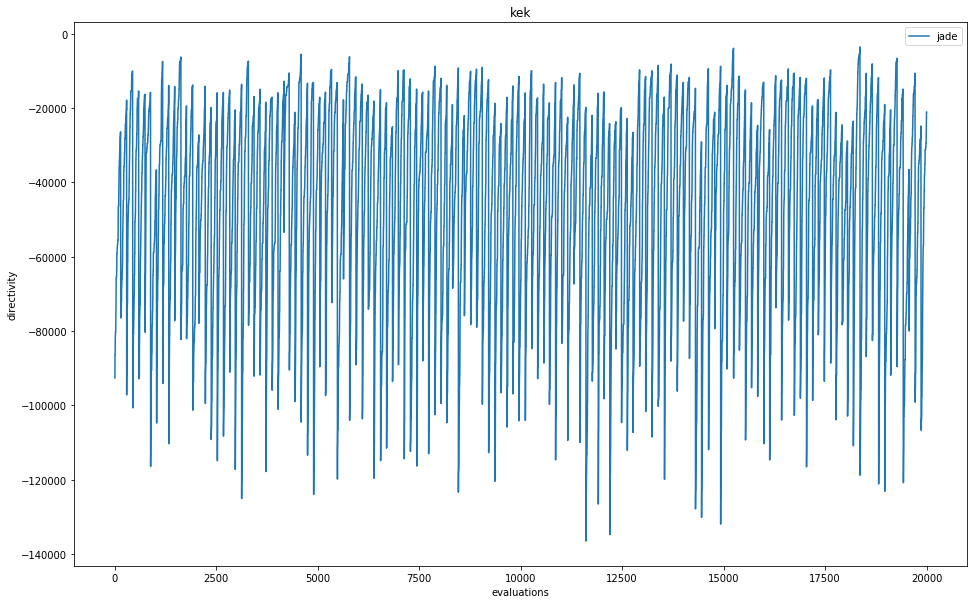

In [73]:
_, _, genetic = run_evaluation(func_n=1, dims=30, algo='genetic', n_it=20000)
_, _, jade = run_evaluation(func_n=1, dims=30, algo='JADE', n_it=20000)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("kek")
plot_hist(jade, "jade")
#plot_hist(genetic, "genetic")
plt.legend();

In [7]:
limitsdict = {'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}

def plot_hist(hist, label, linestyle='-'):
    histarr = np.array(hist)
    xs,ys = histarr[:,0],histarr[:,1]
    plt.plot(xs, ys, linestyle=linestyle, label=label)

In [8]:
%%time

results = []
n_it=1000
retries=1
for sbbx_eta in [0.001, .01, .1, .5, 1.0, 1.5, 5.0, 10.0, 100.0]:
    kek = []
    for _ in range(retries):
        _, _, hist = run_evaluation('genetic', n_it=n_it, layers=5, sbbx_eta=sbbx_eta, log=False, **limitsdict)
        kek.append(hist[-1][1])
    print("{}: {}".format(sbbx_eta, np.array(kek).mean()))

0.001: 6.668770986783339
0.01: 6.15296404848088
0.1: 7.398712456982985
0.5: 5.940296225286354
1.0: 6.70091006966024
1.5: 5.89705486790656
5.0: 5.842585382385108
10.0: 6.4637500926907645
100.0: 6.273629389793842
CPU times: user 1min 10s, sys: 12.6 ms, total: 1min 10s
Wall time: 1min 10s


In [10]:
kek

[6.273629389793842]

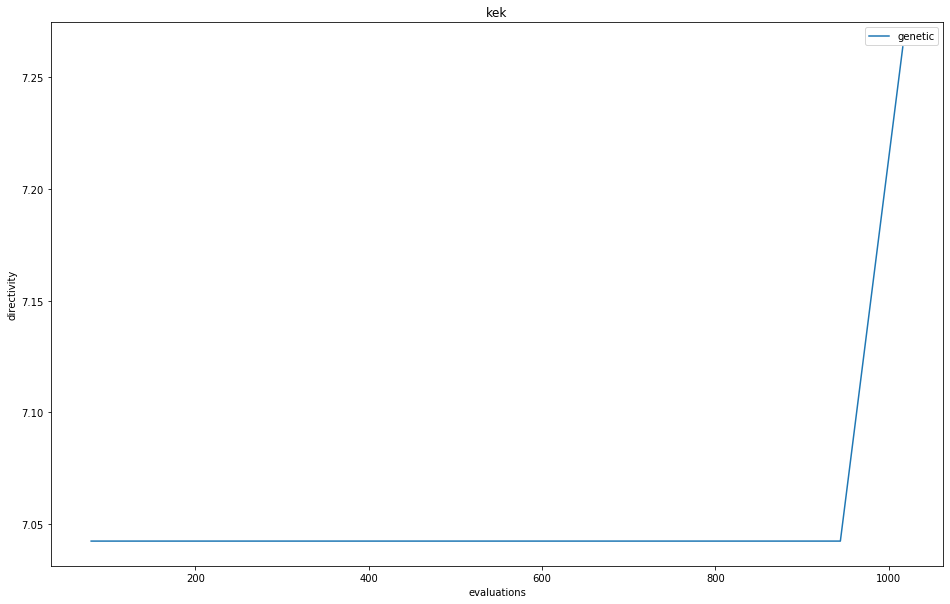

In [13]:
#_, _, hist = run_evaluation('genetic', n_it=n_it, layers=5, sbbx_eta=sbbx_eta, log=False, **limitsdict)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("kek")
plot_hist(hist, "genetic")
plt.legend();